# fitting real Kepler light curves

In [655]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import scipy
from scipy import signal


from astropy.io import fits

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [656]:
nwalk = 64
nsteps_d = 1500
ndiscard_d = 1000
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [657]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

In [658]:
spectplanets = pd.read_csv('spectplanets.csv')
muirhead_comb = pd.read_csv('muirhead_comb.csv')
muirhead_comb_lums = pd.read_csv('muirhead_comb_lums.csv')
muirhead_lamost = pd.read_csv('muirhead_lamost.csv')

In [659]:
KICs = np.sort(np.unique(np.array(muirhead_comb['KIC'])))
KOIs = np.sort(np.unique(np.array(muirhead_comb['KOI'])))

In [660]:
strkois = [str(i) for i in KOIs]

In [661]:
strkois = ['KOI ' + i for i in strkois]

In [662]:
#np.savetxt('MuirheadKOIs.txt', strkois, fmt='%s')

In [663]:
lcpath = '/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/sample_LCs/'
lclist = []

for i in range(len(KICs)):
    templst = []
    for subdir, dirs, files in os.walk(lcpath):
        for file in files:
            if str(KICs[i]) in file:
                templst.append(os.path.join(subdir, file))
    lclist.append(templst)

In [667]:
KOI1 = 4290
KIC1 = 5868793

In [668]:
def get_stitched_lcs(KOI, KIC):
    
    files = lclist[int(np.argwhere(KICs==KIC))]


    files = sorted(files)
    
    time = []
    flux = []
    flux_err = []
    hdus = []
    
    starttimes = []
    stoptimes = []
    
    for file in files:

        hdu = fits.open(file)
        
        time_p = list(hdu[1].data['TIME'] + hdu[1].header['BJDREFI'] + hdu[1].header['BJDREFF'])
        time.append(time_p)
        
        flux_p = hdu[1].data['PDCSAP_FLUX']
        flux_err_p = hdu[1].data['PDCSAP_FLUX_ERR']
        
        fmed = np.nanmedian(flux_p)

        start = hdu[1].header['TSTART'] + hdu[1].header['BJDREFI'] + hdu[1].header['BJDREFF']
        starttimes.append(start)
        
        stop = hdu[1].header['TSTOP'] + hdu[1].header['BJDREFI'] + hdu[1].header['BJDREFF']
        stoptimes.append(stop)
        
        
        flux.append(list(flux_p/fmed))
        flux_err.append(list(flux_err_p/fmed))
        
        hdus.append(hdu)


        #hdu.close()
    
    return hdus, time, flux, flux_err, starttimes, stoptimes

In [669]:
hdus, t, f, fe, starts, stops = get_stitched_lcs(str(KOI1), KIC1)
#hdus[0][1].header

In [670]:
alltime_noclip = []
allflux_noclip = []
allfluxerr_noclip = []

for sublist in t:
    for item in sublist:
        alltime_noclip.append(item)
        
for sublist in f:
    for item in sublist:
        allflux_noclip.append(item)
        
for sublist in fe:
    for item in sublist:
        allfluxerr_noclip.append(item)

In [671]:
def sigma_clip(time, flux, fluxerr, sig=4):
    for i in tqdm(range(len(flux))):
        if flux[i] > np.nanmean(flux) + sig*np.nanstd(flux) or flux[i] < np.nanmean(flux) - sig*np.nanstd(flux):
            time[i] = np.nan
            flux[i] = np.nan
            fluxerr[i] = np.nan
            
    return time, flux, fluxerr
            

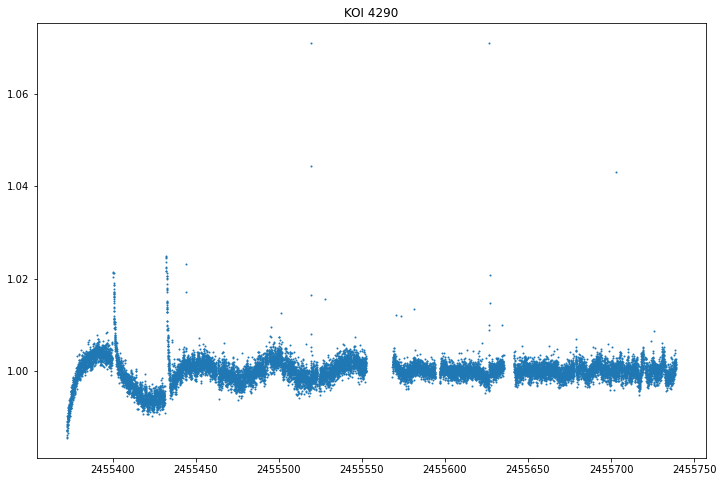

In [673]:
# alltime, allflux, allfluxerr = sigma_clip(alltime_noclip, allflux_noclip, allfluxerr_noclip, sig=4)

alltime, allflux, allfluxerr = alltime_noclip, allflux_noclip, allfluxerr_noclip

plt.scatter(alltime, allflux, s=1)
plt.title('KOI ' + str(KOI1))

plt.ticklabel_format(useOffset=False, style='plain')

# Kepler-1582 b

In [690]:
alltime[0]

2455372.450321894

In [691]:
starts[0]

2455372.44010484

In [692]:
kepid = KIC1
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

In [693]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

In [694]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.17438311970562165 Stellar radius (Rsun):  0.19884797856314
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  33.79155851141583
i (deg):  89.98


In [695]:
transitmpt = 2454968.15620000

In [709]:
midpoints = np.concatenate((np.arange(transitmpt, starts[0], -period), np.arange(transitmpt, stops[-1], period)))

for i in range(len(midpoints)):
    if not starts[0] < midpoints[i] < stops[-1]:
        midpoints[i] = np.nan

In [711]:
midpoints = midpoints[~np.isnan(midpoints)]

In [718]:
# plt.scatter(np.array(alltime)-2454833, allflux, s=2)

# for i in range(len(midpoints)):
#     plt.axvline(midpoints[i]-2454833, c='r')
    
# #plt.axvline(2454967, c='g')
# #plt.axvline(2454967 + period, c='g')
# #plt.axvline(2454965.72900, c='b')
# #plt.axvline(2455022.92667000-period, c='k')
    
# #plt.xlim(alltime[0], alltime[-1])
# #plt.ylim(0.99,1.06)
# plt.xticks(ticks=np.arange(175, 260, 5))
# plt.ticklabel_format(useOffset=False, style='plain')
    

In [719]:
# medfilt = scipy.signal.medfilt(allflux, kernel_size=101)

# plt.scatter(np.array(alltime)-2454900.0, allflux-medfilt+1, s=2)

# #plt.scatter(np.array(alltime)-2454900.0, allflux, s=2)
# #plt.plot(np.array(alltime)-2454900.0, medfilt)

# for i in range(len(midpoints)):
#     plt.axvline(midpoints[i]-2454900.0, c='r')
    
# # plt.axvline(2454967-2454900.0, c='g')
# # plt.axvline(2454967-2454900.0 + period, c='g')
# # plt.axvline(2454965.72900-2454900, c='b')
    
# #plt.xlim(0, 100)
# #plt.ylim(0.998, 1.001)
# #plt.xticks(ticks=np.arange(100, 200, 5))
# plt.ticklabel_format(useOffset=False, style='plain')

In [720]:
#midpoints = np.unique(list(midjd[midjd['planetname'] == 'Kepler-737 b']['midpointjd']))
#midpoints_errs = np.unique(list(midjd[midjd['username'] == 'KOI ' + '947']['propmidpointunc']))

In [721]:
def get_KIC(KOI, muirhead_comb):
    return muirhead_comb[muirhead_comb['KOI'] == str(KOI)].KIC.item()

In [737]:
def fit_Kepler_lc(KOI, midpoints, time, flux, flux_err, period, nbuffer, spectplanets, muirhead_comb):
    
    # Get alt IDs
    kepid = get_KIC(KOI, muirhead_comb)
    kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]
    
    dr = str(KOI)
    direct = 'segfits/' + dr + '_emcee/'

    if not os.path.exists(direct):
        os.mkdir(direct)
    
    # Get stellar params
    isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")
    
    mstar = isodf["mstar"].mean()
    mstar_err = isodf["mstar"].std()

    rstar = isodf["radius"].mean()
    rstar_err = isodf["radius"].std()
    
    # Get planet params
    period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

    # We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
    a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
    a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

    print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
    print('Period (Days): ', period, 'Rp/Rs: ', rprs)
    print('a/Rs: ', a_rs)
    print('i (deg): ', i)
            
    
    for ind in range(len(midpoints)):

        try:
        
            transitmid = midpoints[ind]

            tindex = int(np.where(alltime == ph.find_nearest(alltime, transitmid))[0])

            t1 = np.array(time[tindex-nbuffer:tindex+nbuffer]) - transitmid
            t1bjd = np.array(time[tindex-nbuffer:tindex+nbuffer])
            
            f1 = np.array(flux[tindex-nbuffer:tindex+nbuffer])
            fe1 = np.array(flux_err[tindex-nbuffer:tindex+nbuffer])

            tindex = int(np.where(time == ph.find_nearest(time, transitmid))[0])

            idx = np.isfinite(t1) & np.isfinite(f1)

            disc = 5
            m, b = np.polyfit(np.concatenate((t1[idx][:disc], t1[idx][-disc:])), np.concatenate((f1[idx][:disc], f1[idx][-disc:])), 1)

            linfit = m*t1 + b
            fnorm = (f1-linfit)+1
            
            plt.cla()
            plt.errorbar(t1bjd-2454833, fnorm, yerr=fe1, fmt='o', c='blue')
            #plt.plot(t1bjd-2454833, linfit, c='green')
            plt.xlabel('Time')
            plt.ylabel('Rel. Flux')
            #plt.axvline(0, c='r')
            
            plt.savefig(direct + str(KOI) + 'segment' + str(ind) + '.png')
            
            
            
            mid = ph.get_mid(time)
            ptime = ph.get_ptime(t1, mid, 29)

            fnorm = np.nan_to_num(fnorm, nan=1.0)
            fe1 = np.nan_to_num(fe1, nan=np.nanmedian(fe1))


            # Inital guess: rprs, a/Rs, i, t0
            p0 = [rprs, a_rs, i, 0]

            # EMCEE Transit Model Fitting
            _, _, rdist, adist, idist, t0dist = ph.mcmc_fitter_noper(p0, period, t1, ptime, fnorm, fe1, nwalk, nsteps_d, ndiscard_d, 'X', 'X', direct, plot_Tburnin=False, plot_Tcorner=False)
            
            # Create a light curve with the fit parameters
            mcmcfit = ph.integratedlc_fitter(t1, period, ph.mode(rdist), ph.mode(adist), ph.mode(idist), ph.mode(t0dist))
            truefit = ph.integratedlc_fitter(t1, period, rprs, a_rs, i, 0)

            plt.cla()
            offset = 2454900.0
            plt.errorbar(t1bjd-offset, fnorm, yerr=fe1, c='blue', alpha=0.5, label='Original LC', fmt="o", capsize=0)
            plt.scatter(t1bjd-offset, mcmcfit, c='red', alpha=1.0, label='Fit LC')
            plt.plot(t1bjd-offset, mcmcfit, c='red', alpha=1.0)
            plt.plot(t1bjd-offset, truefit, c='green', alpha=0.4)
            plt.xlabel('BJD-2454900.0')
            
            textstr = '\n'.join((
            r'$\mathrm{Rp/Rs}=%.2f$' % (ph.mode(rdist), ),
            r'$\mathrm{a_rs}=%.2f$' % (ph.mode(adist), ),
            r'$\mathrm{i}=%.2f$' % (ph.mode(idist), ),
            r'$\mathrm{t0}=%.2f$' % (ph.mode(t0dist), )))
            plt.title(textstr)

            plt.legend()
            
            plt.savefig(direct + str(KOI) + 'segment' + str(ind) + 'fit.png')
            
            
        # Skip if transit mid-time falls outside of Kepler observations
        except TypeError:
            continue



  0%|          | 0/1500 [00:00<?, ?it/s]

Stellar mass (Msun):  0.17438311970562165 Stellar radius (Rsun):  0.19884797856314
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  33.79155851141583
i (deg):  89.98


100%|██████████| 1500/1500 [00:38<00:00, 39.18it/s]


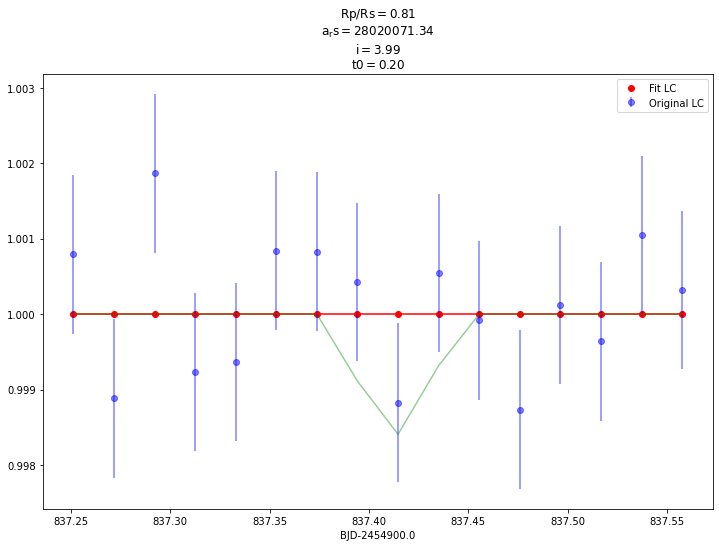

In [738]:
fit_Kepler_lc(KOI1, midpoints, alltime, allflux, allfluxerr, period, 8, spectplanets, muirhead_comb)